In [356]:
using Random
using Statistics
using Plots
using Distributions
using DataFrames
using GLM
using StatsBase
using XLSX
using LinearAlgebra
using Optim

## AR(1)モデルの信頼区間推定

$$y_t = \nu + \phi y_{t-1} + \varepsilon_t, \quad t \geq 1, \: y_0 = y^*_0$$

ただし $$\: E(\varepsilon_t) = 0, \: Var(\varepsilon_t) = \sigma^2, E[y_{t-1}\varepsilon_t] = 0, \: |\phi| ＜ 1 \: \text{を満たす とする（弱定常）} $$

$h$次のインパルス応答関数は $\theta(h) = \phi^h, \:$ $\sigma\:$単位のショックに対しては$\:\sigma \times\theta(h)\:$で求められる。

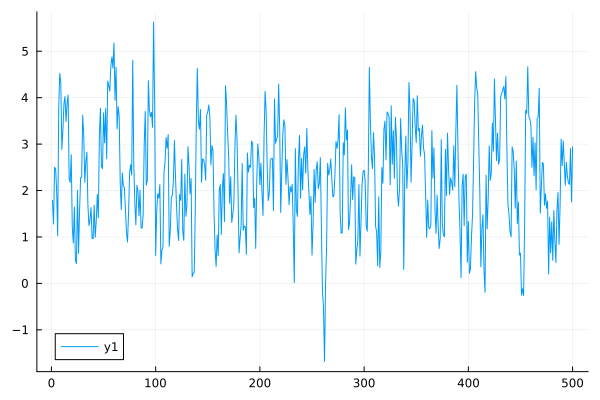

In [119]:
#設定

p = 1 
T = 500
nu = 1
sigma = .9
Dist = Normal(0, sigma^2)
Random.seed!(1234)
Phi = .6 
y0  = .0

#誤差項の生成
e = rand(Dist, T)

#データセットの生成
y = zeros(T + p, 1)
y[1] = y0

for t in p:T
    temp = Phi * y[t]
    y[t+1] = nu + temp[1] + e[t]
end
y = y[2:T+p]
plot(y)

### デルタ法

$\hat{\phi}$と$\hat{\sigma}$は漸近正規性を満たすことが知られている。すなわち、
$$\sqrt{T} (\hat{\phi} - \phi) \xrightarrow{d} N(0,V), \quad, \sqrt{T} (\hat{\sigma} - \sigma) \xrightarrow{d} N(0,W)$$
ただし $y_t$の分散を$\gamma_0$として$\:V = {\sigma^2 \over \gamma_0 },\: W = E(\varepsilon_t^4) - \sigma^4$ である。また、緩い条件（$\:\varepsilon_t\:$がiidで対称な分布に従い、かつ4次モーメントが存在するとき、など）の下で $\:\hat{\phi}\:$と$\:\hat{\sigma}\:$の漸近共分散は$0$となる。

以上より（仮定の下で）、連続微分可能な非線形関数$\:f(\phi, \sigma^2) = \sigma \times \theta(h) = \sigma \phi^h\:$に2変数関数のデルタ法を適用すると 
$$\sqrt{T} (\hat{\sigma} \hat{\phi}^h  - \sigma \phi^h) \xrightarrow{d} N \left(0, (\sigma h \phi^{h-1})^2 V + (\phi^h / 2 \sigma)^2 W  \right) $$
という$h$次のインパルス応答関数の漸近分布が求められる。したがって、$\:\sigma\:$単位のショックに対するインパルス応答関数の$\:100\times(1-\alpha)\%\:$信頼区間は
$$\left[\hat{\sigma} \hat{\phi}^h - |z_{\alpha / 2}| \times SE(\hat{\sigma} \hat{\phi}^h), \: \hat{\sigma} \hat{\phi}^h + |z_{\alpha / 2}| \times SE(\hat{\sigma} \hat{\phi}^h)\right]$$
で与えられる。ただし、
$$ \begin{align*} &SE(\hat{\sigma} \hat{\phi}^h) = \sqrt{\big[(\hat{\sigma} h \hat{\phi}^{h-1})^2 \hat{V} + (\hat{\phi}^h / 2 \hat{\sigma})^2 \hat{W} \big] / T}, \\ &\hat{V} = (\sum_{t = 1}^T \hat{\varepsilon}_t^2 / T) / (\sum_{t = 1}^T y_t^2 / T), \quad \hat{W} = \sum_{t = 1}^T \hat{\varepsilon}_t^4 / T - (\sum_{i = 1}^T \hat{\varepsilon}_t^2 / T)^2\end{align*}$$で与えられる。

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.507551   0.110094    4.61    <1e-05   0.291244   0.723858
x2  0.884915   0.0211652  41.81    <1e-99   0.843331   0.926499
───────────────────────────────────────────────────────────────



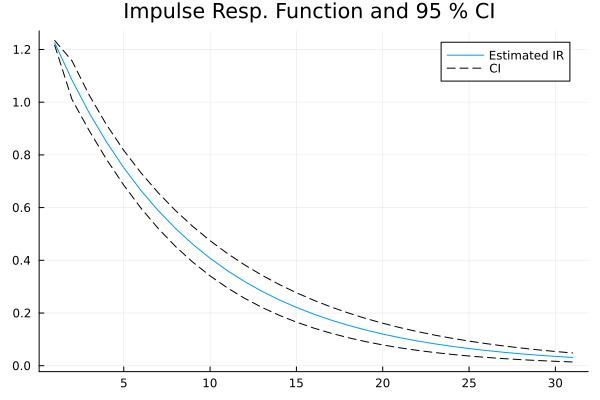

(0.884914895934801, 1.2249238227638)

In [199]:
function DE_AR1(y, alpha)
    T = size(y,1)
    y_dep = y[2:T]
    y_exp = ones(T - 1, 2)
    y_exp[:,2] = y[1:T-1]

    #phiの推定
    model = lm(y_exp, y_dep)
    println(model)
    phi = coef(model)[2]
    err = residuals(model) #推定誤差項

    #分散等の推定値
    gam0 = y'*y / T
    var = (err' * err) / T
    std = sqrt(var)
    mom = (err .* err)' * (err .* err) /T

    V = std / gam0
    W = mom - var^2
    
    plotT = 30 #描画最大期
       
    z_alpha2 = quantile.(Normal(), (1-alpha/2))
    zround = round(Int64, 100 * (1-alpha))
    Resp = zeros(plotT+1) #推定値
    Resp_inf = zeros(plotT+1) #信頼区間下
    Resp_sup = zeros(plotT+1) #信頼区間上
    Resp[1] = std #std単位のショック
    Resp_inf[1] = std-z_alpha2*sqrt(W)/T
    Resp_sup[1] = std+z_alpha2*sqrt(W)/T
    
    for t in 1:30
        Resp[t+1] = Resp[t] * phi
        SE = sqrt(((std * (t-1) * phi^t)^2*V+(phi^t/(2*std))^2*W)/T)
        Resp_inf[t+1] = Resp[t+1] - z_alpha2 * SE
        Resp_sup[t+1] = Resp[t+1] + z_alpha2 * SE
    end
    
    plt = plot(Resp, label = "Estimated IR", title = "Impulse Resp. Function and $zround % CI ")
    plot!(plt, Resp_inf, label = "CI", color = "black", ls = :dash) 
    plot!(plt, Resp_sup, label = "", color = "black", ls = :dash)
    display(plt)

    return phi, std
end
CI_AR1(y, .05)

## AR(p)モデルでの信頼区間（ブートストラップ法）

## 再帰的ブートストラップ法

$100 \times (1 - \alpha) \%$信頼区間の計算方法

1. AR(p)モデルを推定、係数推定値$\:\hat{\Phi}\:$と残差$\: \hat{\varepsilon}\:$を計算する。残差平均が0でないときは中心化する。
2. （中心化した）残差から無作為の復元抽出($T$個)をし、$\:\lbrace\varepsilon_t^*\rbrace_{t = 1}^T\:$とする。
3. 初期条件$\:y_{0:p-1}^* = (y_0, \dots, y_{p-1})'\:$に固定する。
4. 再帰的に$\:y_{t} = \hat{\Phi} y_{t-1}^* + \varepsilon_t^*$に従ってブートストラップ標本を生成
5. ブートストラップ標本を用いてAR(p)モデルを推定、インパルス応答関数を計算
6. ステップ2から5をB回繰り返し、B個のインパルス応答関数推定値を各$\:h\:$について小さい順にならべ、$\:100 \times(\alpha/2) \%$の分位点を信頼区間の下限、$\:100 \times (1 - \alpha /2)\%\:$の分位点を上限とする。

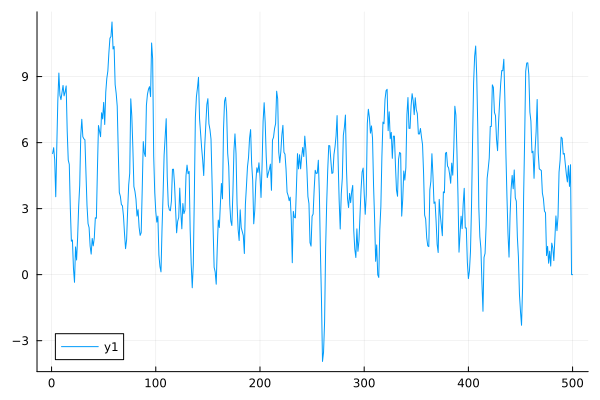

In [273]:
#設定

p = 3 #とする
T = 500
nu = 1
sigma = 1
Dist = Normal(0, sigma^2)
Random.seed!(1234)
Phi = [-.1 -.3 1.2] #左から3次、2次、1次のラグ
y0  = 4.5
y1 = 4.5
y2 = 4.5


#誤差項の生成
e = rand(Dist, T)

#データセットの生成
y = zeros(T + p, 1)
y[1] = y0
y[2] = y1
y[3] = y2

for t in p:T
    temp = Phi * y[t-2:t]
    y[t+1] = nu + temp[1] + e[t]
end
y = y[p+1:T+p]
plot(y)

In [274]:
p_sel = 3

3

In [275]:
#phiのOLS推定
function AR_OLS(y, p_sel)
    T = size(y,1)
    y_dep = y[1+p_sel:T]
    y_exp = ones(T- p_sel, p_sel+ 1)
    for i in 1:p_sel
        y_exp[:,i+1] = y[i:T-p_sel+i-1]
    end
    model = lm(y_exp, y_dep)
    phis = coef(model)[2:p_sel+1]

    std_est =  sqrt(deviance(model)/(T-p_sel-1))
    err = residuals(model)
    
    return phis, std_est, err

end

#インパルス応答関数計算
function AR_IRF(plotT, p_sel, phis, std)
    Resp = zeros(plotT+p_sel-1)
    Resp[p_sel] = std #std単位のショック
   
    for t in 1:plotT-1
        Resp[t+p_sel] = dot(Resp[t:t+p_sel-1], phis)
    end
    Resp = Resp[p_sel:plotT+p_sel-1] #0の初期値削除
    return Resp
end

AR_IRF (generic function with 1 method)

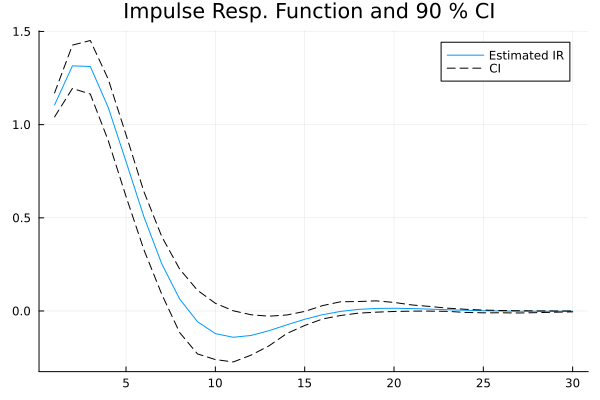

([-0.150953227340722, -0.2287830487123823, 1.189716168637155], 1.1056858094070001)

In [276]:
function BS_ARp(y, p_sel, B, alpha)
    T = size(y,1)
    plotT = 30 #インパルス応答関数描画期間

    #ステップ１：推定
    phis, std, err = AR_OLS(y, p_sel)

    Resp = AR_IRF(plotT, p_sel, phis, std)

    #ステップ３：初期条件固定
    y_rec = copy(y)
    
    Resp_rec = zeros(plotT, B) #インパルス応答関数計算用の空箱

    for i in 1:B
        #ステップ２：無作為抽出
        err_ex = [err[rand(1:T-p_sel)] for _ in 1:T-p_sel]

        #ステップ４：標本生成
        for t in 1:T-p_sel
            y_rec[t+p_sel] = dot(y_rec[t:t+p_sel-1], phis) + err_ex[t]
        end    

        #ステップ５：標本による推定とインパルス応答関数計算
        phis_rec, std_rec, _ = AR_OLS(y_rec, p_sel)

        Resp_rec[:,i] = AR_IRF(plotT, p_sel, phis_rec, std_rec)
    end

    #ステップ６：信頼区間
    zround = round(Int64, 100 * (1-alpha)) #信頼区間alpha
    Resp_inf = [quantile(Resp_rec[t,:], alpha/2; sorted = false) for t in 1:plotT]
    Resp_sup = [quantile(Resp_rec[t,:], (1.0-alpha/2); sorted = false) for t in 1:plotT]

    #プロット
    plt = plot(Resp, label = "Estimated IR", title = "Impulse Resp. Function and $zround % CI ")
    plot!(plt, Resp_inf, label = "CI", color = "black", ls = :dash) 
    plot!(plt, Resp_sup, label = "", color = "black", ls = :dash)
    display(plt)

    return phis, std

end
BS_ARp(y, p_sel, 100, 0.1)

### 実証例（GDPgap）

In [195]:
gap = CSV.read("data_VAR1.csv", DataFrame, header = true)
gap.gapboj = coalesce.(gap.gapboj, 0)
gap

Row,Column1,gapcao,gapboj
,Float64,Float64,Real
1,1980.1,-0.2,0
2,1980.2,-1.7,0
3,1980.3,-0.6,0
4,1980.4,0.3,0
5,1981.1,0.1,0
6,1981.2,0.0,0
7,1981.3,-0.5,0
8,1981.4,-1.0,0
9,1982.1,-0.7,0


In [196]:
y_gap = gap[13:176, 3]

164-element Vector{Real}:
 -1.632983641
 -1.334731611
 -1.07668823
 -0.618551996
 -0.229847241
 -0.063879664
  0.191917705
  0.698263153
  0.661329241
  0.489930061
  0.089906571
 -0.176037487
 -0.165271883
  ⋮
 -1.320156309
 -1.518181437
 -1.84583935
 -1.573295356
 -1.069132122
 -0.696454376
 -0.303337489
 -0.402591707
 -0.345132342
 -0.106019232
 -0.365565047
  0.016017703

In [197]:
#AIC, BICによるラグ次数推定
function Lagorder(y, p_max)
    Mat_IC = zeros(p_max, 3)
    T = size(y, 1)
    
    for p in 1:p_max #pの探索領域最大値
        y_dep = y[1+p:T]
        y_exp = ones(T-p, p+1)
        for i in 1:p
            y_exp[:,i+1] = y[i:T-p+i-1]
        end
        model_temp = lm(y_exp, y_dep)

        Mat_IC[p, :] = [aic(model_temp), aicc(model_temp), bic(model_temp)]
    end
    Mat_IC = DataFrame(Mat_IC, [:AIC, :AIC_adj, :BIC])
    println(Mat_IC) #情報基準を表示

    #各基準ごとに最小にするラグ次数を返す
    min_v = minimum.(eachcol(Mat_IC[!, :]))'
    p_sel = ones(1,3)
    for i in 1:3
        p_sel[1, i] = findall(x -> x == min_v[i], Mat_IC[:,i])[1]
    end
    return p_sel
end
Lagorder(y_gap, 8)

8×3 DataFrame
 Row │ AIC      AIC_adj  BIC     
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │ 320.374  320.525  329.655
   2 │ 291.25   291.504  303.6
   3 │ 291.73   292.117  307.137
   4 │ 292.783  293.332  311.234
   5 │ 293.239  293.98   314.721
   6 │ 294.026  294.992  318.526
   7 │ 294.729  295.953  322.235
   8 │ 294.866  296.384  325.365


1×3 Matrix{Float64}:
 2.0  2.0  2.0

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────
        Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────
x1  0.0012521   0.0501394   0.02    0.9801  -0.0977636   0.100268
x2  0.923235    0.0297647  31.02    <1e-69   0.864455    0.982015
─────────────────────────────────────────────────────────────────



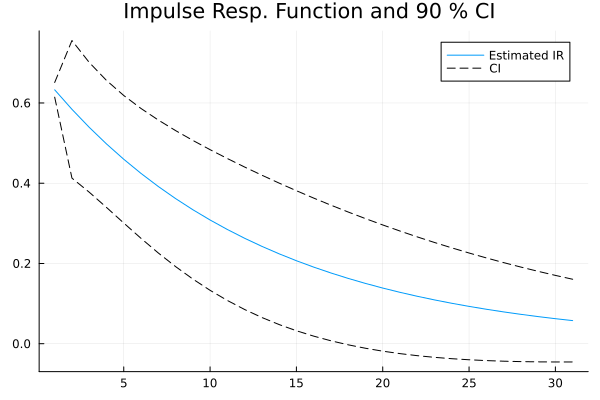

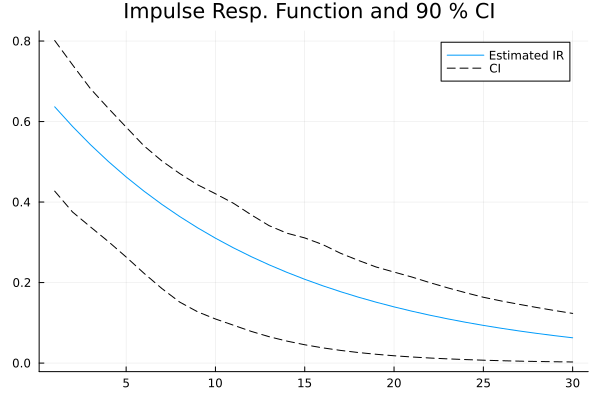

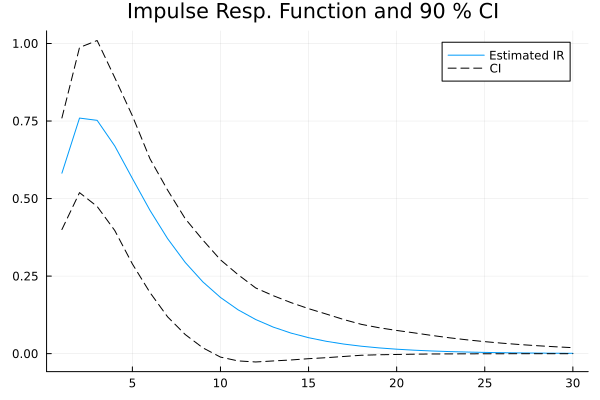

([-0.41118740026954637, 1.3053776598123548], 0.5818077039483887)

In [216]:
#AR(1)でのデルタ法
DE_AR1(y_gap, .10)

#AR(1)でのデルタ法
BS_ARp(y_gap, 1, 300, .10)

#AR(2)でのデルタ法
BS_ARp(y_gap, 2, 300, .10)

## VARの信頼区間推定

デルタ法は行わない

誘導型のVARモデル
$$Y_t = \begin{pmatrix} y_{1t} \\ \vdots \\ y_{nt} \end{pmatrix}= V + \sum_{i = 1}^p \Phi_i Y_{t-i} + E_t $$

ただし $$V = \begin{pmatrix} \nu_1 \\ \vdots \\ \nu_n \end{pmatrix}, \: \Phi_i = \begin{bmatrix} \phi_{11i} & \dots & \phi_{1ni} \\ \vdots & \ddots & \vdots \\ \phi_{n1i} & \dots & \phi_{nni} \end{bmatrix}, \: E_t = \begin{pmatrix} \varepsilon_{1t} \\ \vdots \\ \varepsilon_{nt} \end{pmatrix}, \quad \mathbb{E}(E_t) = O, \: \Sigma_{E_t} = \begin{bmatrix} \sigma_1^2 & \sigma_{12} & \dots & \sigma_{1n} \\ \sigma_{12} & \sigma_2^2 & \dots & \sigma_{2n}\\ \vdots & \vdots  &\ddots &\vdots \\ \sigma_{1n} & \sigma_{2n} & \dots & \sigma_{n}^2  \end{bmatrix} \quad \text{とする} $$

構造ショック
$$E_t = C e_t = \begin{bmatrix} c_{11} &\dots & c_{1n} \\ \vdots &\ddots &\vdots \\ c_{n1} & \dots & c_{nn} \end{bmatrix} \begin{pmatrix} e_{1t} \\ \vdots \\ e_{nt} \end{pmatrix}$$
ただし $$\mathbb{E}(e_t) = O, \: \Sigma_{e_t} = I \quad \text{とする}$$

### 再帰的ブートストラップ法

$100 \times (1 - \alpha) \%$信頼区間の計算方法

1. VAR(p)モデルを推定、係数推定値$\:\lbrace\hat{\Phi}_{i}\rbrace_{i = 1}^p\:$と残差$\: \lbrace \hat{E}_t \rbrace_{t =1}^T\:$を計算する。残差平均が0でないときは中心化する。
2. （中心化した）残差の （常に時点$\:t\:$をそろえた）「ペア」 から無作為の復元抽出($T$個)をし、$\:\lbrace E_t^*\rbrace_{t = 1}^T\:$とする。
4. 初期条件$\:Y_{0:p-1}^* = (Y_0, \dots, Y_{p-1})'\:$を固定する。
5. 再帰的な公式$\:Y_{t}^* = \sum_{i = 1}^p \hat{\Phi}_i Y_{t-i}^* + E_t^*$に従ってブートストラップ標本を生成
6. ブートストラップ標本を用いてVAR(p)モデルを推定、インパルス応答関数を計算
7. ステップ2から5をB回繰り返し、B個のインパルス応答関数推定値を各$\:h\:$について小さい順にならべ、$\:100 \times(\alpha/2) \%$の分位点を信頼区間の下限、$\:100 \times (1 - \alpha /2)\%\:$の分位点を上限とする。

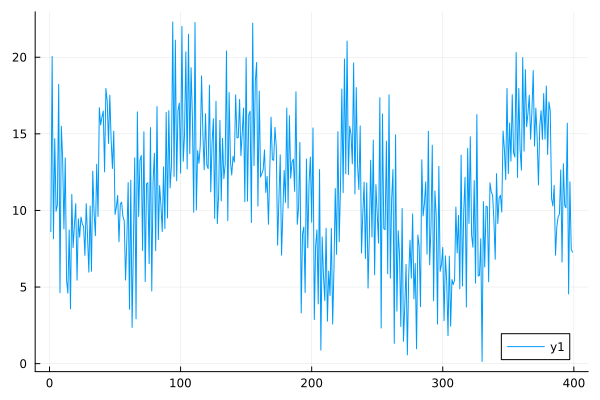

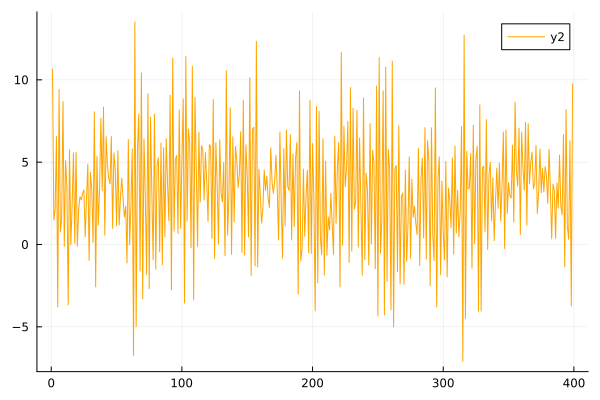

In [450]:
#設定

n = 2 #変量
p = 2 #ラグ次数
T = 500

Nu = [1.0; 2.0]
C = [0 2; 1.0 1.5] #c_11 = 0の短期制約を仮定しておく

Phis = [[.8 -.2; .5 0.1], [-.05 .7; -.3 -.4]] #左上からphi_11, phi_12, phi_21, phi_22, 左からPhi^p, .., Phi^1

y0 = [.0  .0; .0 .0]


#誤差項の生成
Random.seed!(1234)
e = randn(T, n)

#データセットの生成
y = zeros(T+p, n)
y[1:p, :] = y0
for t in p+1:T
    temp = [.0; .0]
    for i in 1:p
        temp += Phis[i] * y[t+i-p,:]
    end
    err = C * e[t,:]
    y[t+1,:] = Nu + temp + err
end
y = y[p+100:T,:]

display(plot(y[:,1], label = "y1"))
display(plot(y[:,2], label = "y2", linecolor = "orange"))

In [451]:
function LagorderVAR(y, p_max)
    T = size(y, 1)
    n = size(y, 2)
    Mat_IC = zeros(p_max, 2)
    
    for p in 1:p_max #pの探索領域最大値
        y_dep = y[1+p:T,:]
        y_exp = ones(T-p, n*p+1)
        for j in 1:p #各ラグ次数ｊに対して
            for k in 1:n #各ykに対して
                y_exp[:,n*(j-1)+k+1] = y[j : T-p+j-1, k]
            end
        end
        #y_expは定数項、y_{1,t-p}, y_{2,t-p}, y_{1, t-p+1}, ..., y_{1, t-1}, y_{2, t-1}の順
        
        temp_err = zeros(T-p, n)
        Mat_Sigma = zeros(n,n) #分散共分散行列
        for k in 1:n 
            model_temp = lm(y_exp, y_dep[:,k])
            temp_err[:,k] = residuals(model_temp)
            Mat_Sigma[k,k] = deviance(model_temp) #分散
        end
        
        
        for i in 1:n
            for j in i+1:n
                Mat_Sigma[i,j] = cov(temp_err[:,i], temp_err[:,j]) #共分散
                Mat_Sigma[j,i] = Mat_Sigma[i,j]
            end
        end
        detS = det(Mat_Sigma)
        Mat_IC[p,:] = [log(detS)+(p*n^2+n)*2/T log(detS)+(p*n^2+n)*log(T)/T]
        
    end
    Mat_IC = DataFrame(Mat_IC, [:AIC, :BIC])

    println(Mat_IC) #情報基準を表示

    #各基準ごとに最小にするラグ次数を返す
    min_v = minimum.(eachcol(Mat_IC[!, :]))'

    p_sel = [findall(x -> x == min_v[1], Mat_IC[:,1])[1] findall(x -> x == min_v[2], Mat_IC[:,2])[1]]
    
    return p_sel
end

LagorderVAR (generic function with 1 method)

In [452]:
LagorderVAR(y, 12)

12×2 DataFrame
 Row │ AIC      BIC     
     │ Float64  Float64 
─────┼──────────────────
   1 │ 16.745   16.805
   2 │ 14.6138  14.7138
   3 │ 14.6235  14.7635
   4 │ 14.6338  14.8137
   5 │ 14.6418  14.8617
   6 │ 14.6534  14.9133
   7 │ 14.6695  14.9694
   8 │ 14.6832  15.0232
   9 │ 14.6935  15.0734
  10 │ 14.6767  15.0966
  11 │ 14.6825  15.1424
  12 │ 14.6968  15.1967


1×2 Matrix{Int64}:
 2  2

In [505]:
#VARのOLS推定
function VAR_OLS(y, p_sel)
    T = size(y,1)
    n = size(y,2)

    y_dep = y[1+p_sel:T,:]
    y_exp = ones(T-p_sel, n*p_sel+1)
    for j in 1:p_sel #各ラグ次数ｊに対して
        for k in 1:n #各ykに対して
            y_exp[:,n*(j-1)+k+1] = y[j : T-p_sel+j-1, k]
        end
    end
    #y_expは定数項、y_{1,t-p}, y_{2,t-p}, ..., y_{n, t-p}, ..., y_{1, t-p+1}, ..., y_{n, t-1}の順
    
    temp_err = zeros(T-p_sel, n)
    Mat_Sigma = zeros(n,n) #分散共分散行列
    phis = zeros(n, n*p_sel)
    for k in 1:n 
        model = lm(y_exp, y_dep[:,k])
        phis[k,:] = coef(model)[2:n*p_sel+1]
        temp_err[:,k] = residuals(model)
        Mat_Sigma[k,k] = deviance(model)/(T-p-1) #不偏分散
    end
    #phisは [phi_11^p phi_12^p ... phi_1n^p phi_1n^{p-1} ... phi_1n^1; ... ; phi_n1^p ... phi_nn^1]
    
    Phis = [phis[:,(j-1)*n+1:j*n] for j in 1:p_sel] 
    #[[phi_11^p phi_12^p ... phi_1n^p; phi_21^p ...; phi_n1^p ... phi_nn^p]
    # [phi_11^[p-1} ...], ...,
    #[phi_11^1 ...; ...; ... phi_nn^1]]
    #に変換
    
    for i in 1:n
        for j in i+1:n
            Mat_Sigma[i,j] = cov(temp_err[:,i], temp_err[:,j]) #不偏共分散
            Mat_Sigma[j,i] = Mat_Sigma[i,j]
        end
    end
    
    C_est  =Struc_Coef_Est(Mat_Sigma)

    return Phis, C_est, temp_err
end

#インパルス応答関数計算
function VAR_IRF(plotT, p_sel, Phis, shocks)
    n = size(Phis[1], 1)
    Resp = zeros(plotT+p_sel-1, n)
    Resp[p_sel,:] = shocks #std単位のショック
   
    for t in 1:plotT-1
        for i in 1:p_sel
            Resp[t+p_sel,:] .+= Phis[i] * Resp[t+i-1, :]
        end
    end
    Resp = Resp[p_sel:plotT+p_sel-1, :] #0の初期値削除
    return Resp
end

function Struc_Coef_Est(Mat) #c_11 = 0の短期制約を満たすようにしている
    C = [.0 sqrt(Mat[1,1]); sqrt(Mat[2,2]-Mat[1,2]^2/Mat[1,1]) Mat[1,2]/sqrt(Mat[1,1])]
    return C
end

Struc_Coef_Est (generic function with 2 methods)

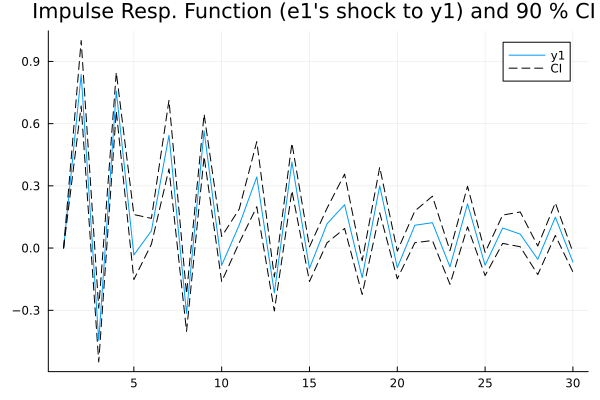

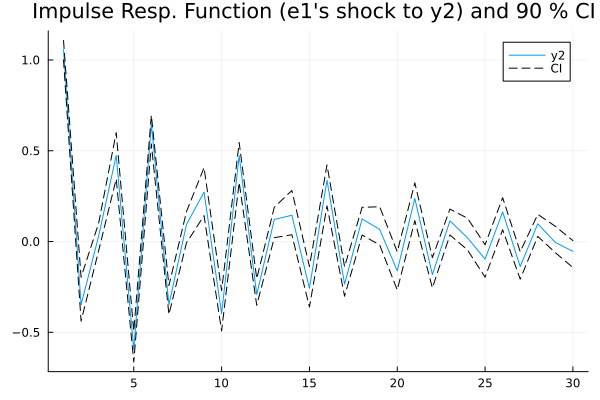

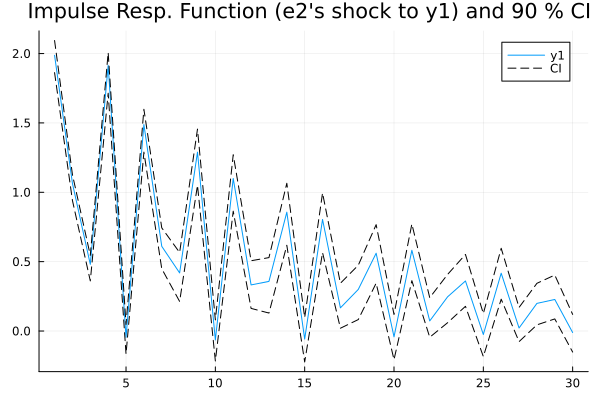

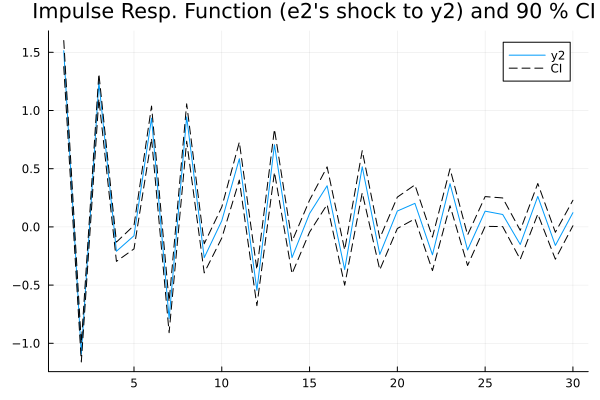

([[0.7950905952075754 -0.10732157326858405; 0.48485190573677567 0.15699676877930832], [-0.06745462642823001 0.7913153166172525; -0.29920344023331097 -0.3295205811864221]], [0.0 1.9875593398061702; 1.057570034386709 1.5141549565815238])

In [506]:
#VARのインパルス応答関数とCI
function BS_VAR(y, p_sel, B, alpha, plotT::Int = 30)
    T = size(y,1)
    n = size(y,2)

    #ステップ１：推定
    Phis, C, err = VAR_OLS(y, p_sel)
    Resp = [zeros(plotT, n) for _ in 1:n]
    for i in 1:n
        shocks = zeros(n)
        shocks[i] = 1.0
        shocks = C * shocks
        
        Resp[i] = VAR_IRF(plotT, p_sel, Phis, shocks) 
        #Resp[i][:,j]は、i番目の変数のショックがj番目の変数に与える影響
    end

    Resp_rec = [[zeros(plotT, B), zeros(plotT, B)] for _ in 1:n^2]
       
    for i in 1:B
        #ステップ２：復元抽出
        err_rec = [err[rand(1:T-p_sel), :] for _ in 1:T-p_sel]
        
        #ステップ３：初期値設定
        y_rec = copy(y)
        
        #ステップ４：標本精製
        for t in 1:T-p_sel
            temp = [.0; .0]
            for i in 1:p_sel
                temp .+= Phis[i] * y_rec[t+i-1,:]
            end
            y_rec[t+p_sel, :] = temp .+ err_rec[t]
        end

        #ステップ５：VAR推定とインパルス応答関数計算
        Phis_rec, C_rec, _ = VAR_OLS(y_rec, p_sel)
        
        for j in 1:n
            shocks = zeros(n)
            shocks[j] = 1.0
            shocks = C_rec * shocks
            for k in 1:n
                Resp_rec[j][k][:,i] = VAR_IRF(plotT, p_sel, Phis_rec, shocks)[:,k]
                #Resp_rec[j][k][:,i]は、j番目の変数のショックがk番目の変数に与える影響の、i番目の標本
            end
        end
    end
    
    #ステップ６：信頼区間
    Resp_inf = [zeros(plotT, n) for _ in 1:n]
    Resp_sup = [zeros(plotT, n) for _ in 1:n]

    zround = round(Int64, 100 * (1-alpha))
    for i in 1:n
        for j in 1:n
        Resp_inf[i][:,j] = [quantile(Resp_rec[i][j][t,:], alpha/2; sorted = false) for t in 1:plotT]
        Resp_sup[i][:,j] = [quantile(Resp_rec[i][j][t,:], 1.0-alpha/2; sorted = false) for t in 1:plotT]
        end
    end

    for i in 1:n
        for j in 1:n
            plt = plot(Resp[i][:,j], title = "Impulse Resp. Function (e$i's shock to y$j) and $zround % CI ", label = "y$j")
            plot!(Resp_inf[i][:,j], label = "CI", color = "black", ls = :dash)
            plot!(Resp_sup[i][:,j], label = "", color  ="black", ls = :dash)
           display(plt)
        end
    end
    
    return Phis, C   
end

Phis, C = BS_VAR(y, 2, 50, .1)

### 実証例（物価と金利）

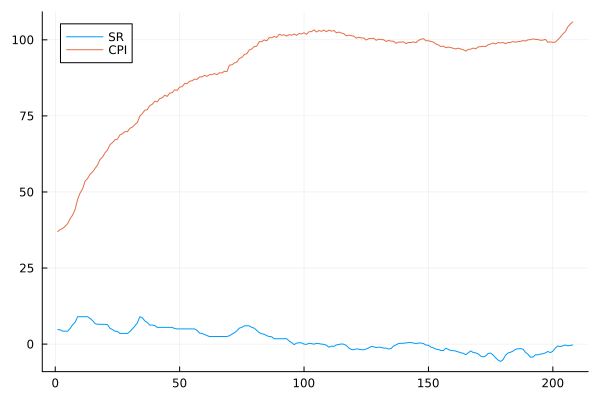

In [455]:
macrodata = DataFrame(XLSX.readtable("data_VAR3.xlsx", "data_q"))
md = Matrix(@. Float64(macrodata[:, 1:2]))
plot(md[:,1], label = "SR")
plot!(md[:,2], label = "CPI")

In [507]:
function VAR_OLS(y, p_sel)
    T = size(y,1)
    n = size(y,2)

    y_dep = y[1+p_sel:T,:]
    y_exp = ones(T-p_sel, n*p_sel+1)
    for j in 1:p_sel #各ラグ次数ｊに対して
        for k in 1:n #各ykに対して
            y_exp[:,n*(j-1)+k+1] = y[j : T-p_sel+j-1, k]
        end
    end
    #y_expは定数項、y_{1,t-p}, y_{2,t-p}, ..., y_{n, t-p}, ..., y_{1, t-p+1}, ..., y_{n, t-1}の順
    
    temp_err = zeros(T-p_sel, n)
    Mat_Sigma = zeros(n,n) #分散共分散行列
    phis = zeros(n, n*p_sel)
    for k in 1:n 
        model = lm(y_exp, y_dep[:,k])
        phis[k,:] = coef(model)[2:n*p_sel+1]
        temp_err[:,k] = residuals(model)
        Mat_Sigma[k,k] = deviance(model)/(T-p-1) #不偏分散
    end
    #phisは [phi_11^p phi_12^p ... phi_1n^p phi_1n^{p-1} ... phi_1n^1; ... ; phi_n1^p ... phi_nn^1]
    
    Phis = [phis[:,(j-1)*n+1:j*n] for j in 1:p_sel] 
    #[[phi_11^p phi_12^p ... phi_1n^p; phi_21^p ...; phi_n1^p ... phi_nn^p]
    # [phi_11^[p-1} ...], ...,
    #[phi_11^1 ...; ...; ... phi_nn^1]]
    #に変換
    
    for i in 1:n
        for j in i+1:n
            Mat_Sigma[i,j] = cov(temp_err[:,i], temp_err[:,j]) #不偏共分散
            Mat_Sigma[j,i] = Mat_Sigma[i,j]
        end
    end
    
    C_est = Struc_Coef_Est2(Mat_Sigma)

    return Phis, C_est, temp_err
end

function Struc_Coef_Est2(Mat) #c_21 = 0の短期制約を満たすようにしている
    C = [sqrt(Mat[1,1]-Mat[1,2]^2/Mat[2,2]) Mat[1,2]/sqrt(Mat[2,2]); 0 sqrt(Mat[2,2])]
    return C
end

Struc_Coef_Est2 (generic function with 2 methods)

$$\begin{bmatrix} \sigma_1^2 & \sigma_{12} \\ \sigma_{12} & \sigma_{2}^2 \end{bmatrix} = \begin{bmatrix} c_{11}^2 + c_{12}^2 & c_{11} c_{21} + c_{12} c_{22} \\ c_{11} c_{21} + c_{12}c_{22} & c_{21}^2 + c_{22}^2 \end{bmatrix} = \begin{bmatrix} c_{11}^2 + c_{12}^2 & c_{12} c_{22} \\ c_{12}c_{22} & c_{22}^2 \end{bmatrix}$$
従って
$$\left\{ \begin{align*} c_{12} &= {\sigma_{12}/\sigma_2} \\ c_{11} &= \sqrt{\sigma_1^2 - {\sigma_{12}^2 \over \sigma_2^2} }\\ c_{22} &= \sigma_2 \end{align*} \right.$$

In [457]:
LagorderVAR(md, 12)

12×2 DataFrame
 Row │ AIC      BIC     
     │ Float64  Float64 
─────┼──────────────────
   1 │ 7.86389  7.96016
   2 │ 7.50435  7.66481
   3 │ 7.17443  7.39907
   4 │ 7.17998  7.46881
   5 │ 6.90055  7.25356
   6 │ 6.83257  7.24976
   7 │ 6.851    7.33238
   8 │ 6.83679  7.38235
   9 │ 6.52374  7.13348
  10 │ 6.4822   7.15612
  11 │ 6.50399  7.2421
  12 │ 6.47612  7.27842


1×2 Matrix{Int64}:
 12  9

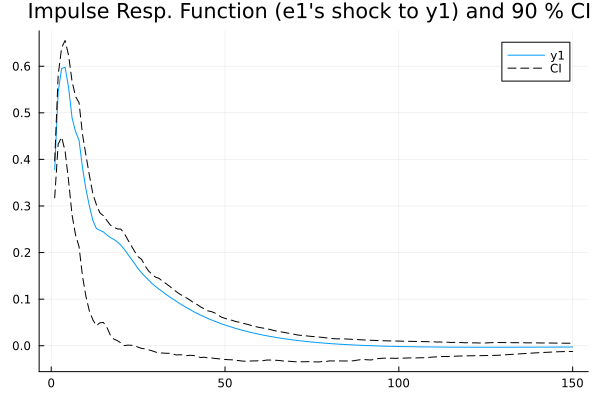

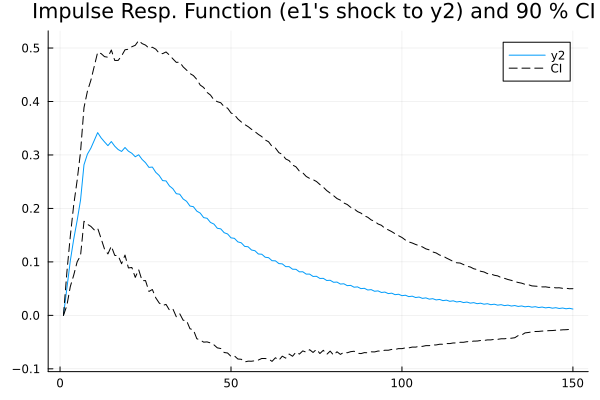

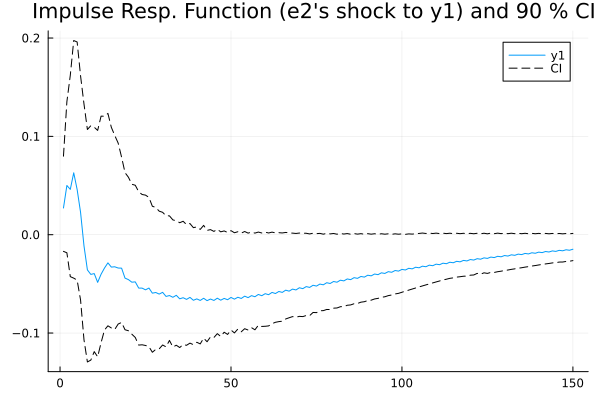

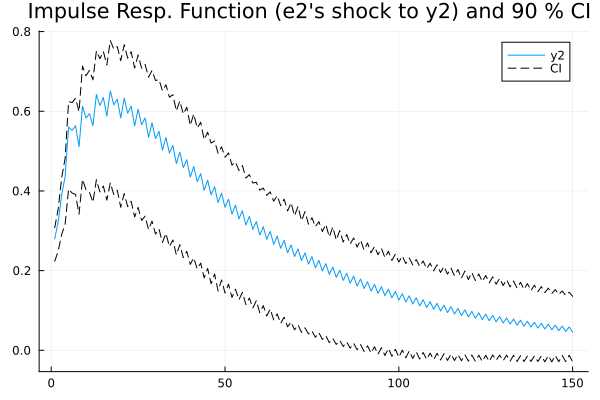

([[0.09885378091105018 -0.10344442823321948; -0.014253450001759694 -0.3493604183913514], [-0.10093024665702857 0.13673305862717028; 0.05546077271339571 0.5525487462841767], [-0.07201826618306408 0.011529914731369783; -0.16430315955676375 -0.09216653253140093], [0.11442703125688201 0.002055498164323712; 0.11935638470850175 0.08041479480333791], [0.03908538408959005 0.029498638426461502; -0.008011662373844538 -0.542148007769777], [-0.0840773878900219 -0.15319478611154194; 0.002703989352778661 0.24963322497179746], [0.04103960164799497 0.12200852910162649; -0.041571814082420035 -0.10945573116743366], [-0.5035957862106012 -0.0891319544444617; -0.07471126851647263 0.06783144123291959], [1.439639706003173 0.03919007028016932; 0.1335860929850287 1.137625903002274]], [0.37810215400895153 0.027174358715220934; 0.0 0.27976143258293545])

In [510]:
function BS_VAR(y, p_sel, B, alpha, plotT::Int = 30)
    T = size(y,1)
    n = size(y,2)

    #ステップ１：推定
    Phis, C, err = VAR_OLS(y, p_sel)
    Resp = [zeros(plotT, n) for _ in 1:n]
    for i in 1:n
        shocks = zeros(n)
        shocks[i] = 1.0
        shocks = C * shocks
        
        Resp[i] = VAR_IRF(plotT, p_sel, Phis, shocks) 
        #Resp[i][:,j]は、i番目の変数のショックがj番目の変数に与える影響
    end

    Resp_rec = [[zeros(plotT, B), zeros(plotT, B)] for _ in 1:n]
       
    for i in 1:B
        #ステップ２：復元抽出
        err_rec = [err[rand(1:T-p_sel), :] for _ in 1:T-p_sel]
        
        #ステップ３：初期値設定
        y_rec = copy(y)
        
        #ステップ４：標本精製
        for t in 1:T-p_sel
            temp = [.0; .0]
            for i in 1:p_sel
                temp .+= Phis[i] * y_rec[t+i-1,:]
            end
            y_rec[t+p_sel, :] = temp .+ err_rec[t]
        end

        #ステップ５：VAR推定とインパルス応答関数計算
        Phis_rec, C_rec, _ = VAR_OLS(y_rec, p_sel)

        for j in 1:n
            shocks = zeros(n)
            shocks[j] = 1.0
            shocks = C_rec * shocks
                
            for k in 1:n
                Resp_rec[j][k][:,i] = VAR_IRF(plotT, p_sel, Phis_rec, shocks)[:,k]
                #Resp_rec[j][k][:,i]は、j番目の変数のショックがk番目の変数に与える影響の、i番目の標本
            end
        end
    end
    
    #ステップ６：信頼区間
    Resp_inf = [zeros(plotT, n) for _ in 1:n]
    Resp_sup = [zeros(plotT, n) for _ in 1:n]

    zround = round(Int64, 100 * (1-alpha))
    for i in 1:n
        for j in 1:n
            Resp_inf[i][:,j] = [quantile(Resp_rec[i][j][t,:], alpha/2; sorted = false) for t in 1:plotT]
            Resp_sup[i][:,j] = [quantile(Resp_rec[i][j][t,:], 1.0-alpha/2; sorted = false) for t in 1:plotT]
        end
    end

    for i in 1:n
        for j in 1:n
            plt = plot(Resp[i][:,j], title = "Impulse Resp. Function (e$i's shock to y$j) and $zround % CI ", label = "y$j")
            plot!(Resp_inf[i][:,j], label = "CI", color = "black", ls = :dash)
            plot!(Resp_sup[i][:,j], label = "", color  ="black", ls = :dash)
           display(plt)
        end
    end
    
    return Phis, C
end

Phis, C = BS_VAR(md, 9, 200, .1, 150)